In [10]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
from scipy.io import loadmat
from pathlib import Path
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_rel
from scipy.signal import butter, filtfilt
import mne
import eeg_analysis.funcs4eeg as fe
import re
import imp
import ast
import behavior.func4behav as fb
imp.reload(fe)
imp.reload(fb)
import matplotlib

from scipy import signal
from scipy.signal import resample
from scipy.ndimage import zoom

### for endo or exo

In [11]:
def align_slow(eeg, case, fs):
    if 'endo' in case:
        jump_from, jump_to = int((1.5+1+0.5)*fs), int((1.5+1+1)*fs)
    elif 'exo' in case:
        jump_from, jump_to = int((1.5+0.033*4+0.5)*fs), int((1.5+0.033*4+1)*fs)
    
    for channel in range(len(eeg)):
        eeg[channel] = np.concatenate((eeg[channel][:,:jump_from], eeg[channel][:,jump_to:]), axis=1)
        
    return eeg

case_title = 'endo' # switch 'endo' or 'exo' HERE!
case_list = [case_title+' fast', case_title+' slow']
if 'endo' in case_title:
    tmax_list = [1.5+1+0.5+0.05+0.2, 1.5+1+1+0.05+0.2]
else:
    tmax_list = [1.5+0.033*4+0.5+0.05+0.2, 1.5+0.033*4+1+0.05+0.2]

fs = 1200
for i, case in enumerate(case_list):
    tmax = tmax_list[i]
    watch = '1 fixation'
    tmin = 0 # include fix or not?

    highpass = None
    lowpass = None

    sb, sa, rb, ra = fe.pipeline_session_channel(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), detrend=1)
    
    if 'slow' in case:
        # sham_before_slow = align_slow(sb, case, fs)
        # sham_after_slow = align_slow(sa, case, fs)
        # real_before_slow = align_slow(rb, case, fs)
        # real_after_slow = align_slow(ra, case, fs)

        sham_before_slow = sb
        sham_after_slow = sa
        real_before_slow = rb
        real_after_slow = ra

    else:
        sham_before_fast = sb
        sham_after_fast = sa
        real_before_fast = rb
        real_after_fast = ra

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tes-attention\processing\behavior\func4behav.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_compare, new_row], ignore_index=True)
c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tes-attention\processing\behavior\func4behav.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_

In [12]:
freq_bands = [[4, 8], [8, 12], [12, 30], [30, 50]]
# exclude fixation
endo_fast_interval = [1.5+1, 1.5+1+0.5]
# endo_slow_interval = [1.5+1, 1.5+1+0.5+0.05+0.2]
endo_slow_interval = [1.5+1, 1.5+1+1]
exo_fast_interval = [1.5+0.033*4, 1.5+0.033*4+0.5]
# exo_slow_interval = [1.5+0.033*4, 1.5+0.033*4+0.5]
exo_slow_interval = [1.5+0.033*4, 1.5+0.033*4+1]

if 'endo' in case_title:
    intervals = [endo_fast_interval, endo_slow_interval]
else:
    intervals = [exo_fast_interval, exo_slow_interval]

slow_sessions = [sham_before_slow, sham_after_slow, real_before_slow, real_after_slow]
fast_sessions = [sham_before_fast, sham_after_fast, real_before_fast, real_after_fast]

In [13]:
bp_table = np.zeros((4, 32, 4)) # 4 sessions, 32 channels, 4 frequency bands

for channel in range(32):
    for k, band in enumerate(freq_bands):
        for i in range(4):
            fast_session = fast_sessions[i][channel]
            slow_session = slow_sessions[i][channel]
            tmp = np.empty(())
            for j, data in enumerate([fast_session, slow_session]):
                interval = intervals[j]
                t_start, t_end = int(interval[0]*fs), int(interval[1]*fs)
                psds, freqs = mne.time_frequency.psd_array_multitaper(data[:,t_start:t_end], fs, fmin=2, fmax=51, verbose=False)
                bp = fe.band_power(psds, freqs, band)
                tmp = np.append(tmp, bp)
            tmp = fe.rm_outlier(tmp, lower_k=3, upper_k=100, verbose=False)
            bp_table[i, channel, k] = np.mean(tmp)
# 13s

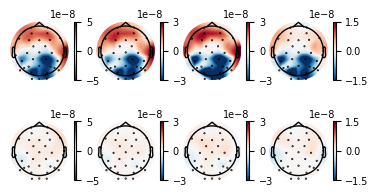

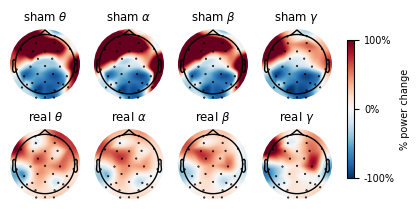

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

bp_subtracts = np.zeros((2, 32, 4))
bp_subtracts_norm = np.zeros((2, 32, 4))
bp_subtracts[0,:,:] = bp_table[1,:,:] - bp_table[0,:,:]
bp_subtracts[1,:,:] = bp_table[3,:,:] - bp_table[2,:,:]
bp_subtracts_norm[0,:,:] = bp_subtracts[0,:,:] / bp_table[0,:,:]
bp_subtracts_norm[1,:,:] = bp_subtracts[1,:,:] / bp_table[2,:,:]

raw = fe.channel_pos()

band_names = ['$\u03B8$', '$\u03B1$', '$\u03B2$', '$\u03B3$']
group_names = ['sham', 'real']

cm = 1/2.54
fig, axes = plt.subplots(nrows=len(group_names), ncols=len(band_names), figsize=(9.4*cm, 5*cm))
cbar_lim = [(-5e-8, 5e-8), (-3e-8, 3e-8), (-3e-8, 3e-8), (-1.5e-8, 1.5e-8)]

for k, band_name in enumerate(band_names):
    for i, group_name in enumerate(group_names):
        ax = axes[i, k]  # Get the correct axis from the grid
        im, cn = mne.viz.plot_topomap(bp_subtracts[i,:,k], pos=raw.info, axes=ax, show=False, contours=0, vlim=cbar_lim[k])
        # Add title to each subplot
        # ax.set_title(group_name + ' ' + band_name)

        # Create an axis for the color bar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        
        # Add the color bar to the current subplot
        cbar = plt.colorbar(im, cax=cax, orientation='vertical')
        cbar.set_ticks([cbar_lim[k][0], 0, cbar_lim[k][1]])


# fig.suptitle(case_title, fontsize=20, y=1.08)
matplotlib.rcParams.update({'font.size': 7})
fig.subplots_adjust(left=0.01, bottom=0.01, right=0.89, top=0.94)
plt.subplots_adjust(wspace=0.3)
# plt.tight_layout()
save_path = os.path.join('..', '..', '..', '..', 'paper', 'Figure 4', case_title+'_topos.eps')
plt.savefig(save_path, format='eps')
plt.show()

cm = 1/2.54
fig, axes = plt.subplots(nrows=len(group_names), ncols=len(band_names), figsize=(9.4*cm, 5*cm))
cbar_lim = (-1, 1)

for k, band_name in enumerate(band_names):
    for i, group_name in enumerate(group_names):
        ax = axes[i, k]  # Get the correct axis from the grid
        im, cn = mne.viz.plot_topomap(bp_subtracts_norm[i,:,k], pos=raw.info, axes=ax, show=False, contours=0, vlim=cbar_lim)
        # Add title to each subplot
        ax.set_title(group_name + ' ' + band_name)

# Add a colorbar to the right of the subplots grid
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_ticks([-1, 0, 1])
cbar.set_ticklabels(['-100%', '0%', '100%'])
cbar.set_label('% power change')
# fig.suptitle(case_title + ', by %', fontsize=20, y=1.1)
matplotlib.rcParams.update({'font.size': 7})
fig.subplots_adjust(left=0.01, bottom=0.01, right=0.88, top=0.94)
save_path = os.path.join('..', '..', '..', '..', 'paper', 'Figure S3', case_title+'_topos_norm.eps')
# plt.savefig(save_path, format='eps')
plt.show()

### For Fixation

In [15]:
case_title = 'Fix'
case = 'all'
fs = 1200
tmax = 1.5
watch = '1 fixation'
tmin = 0 # include fix or not?

highpass = None
lowpass = None

sb, sa, rb, ra = fe.pipeline_session_channel(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), detrend=1)

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tes-attention\processing\behavior\func4behav.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_compare, new_row], ignore_index=True)


In [16]:
bp_table = np.zeros((4, 32, 4)) # 4 sessions, 32 channels, 4 frequency bands
interval = [0, 1.5]
t_start, t_end = int(interval[0]*fs), int(interval[1]*fs)
sessions = [sb, sa, rb, ra]

for channel in range(32):
    for k, band in enumerate(freq_bands):
        for i, session in enumerate(sessions):
            tmp = np.empty(())
            data = session[channel]
            psds, freqs = mne.time_frequency.psd_array_multitaper(data[:,t_start:t_end], fs, fmin=2, fmax=51, verbose=False)
            bp = fe.band_power(psds, freqs, band)
            tmp = np.append(tmp, bp)
            tmp = fe.rm_outlier(tmp, lower_k=3, upper_k=100, verbose=False)
            bp_table[i, channel, k] = np.mean(tmp)

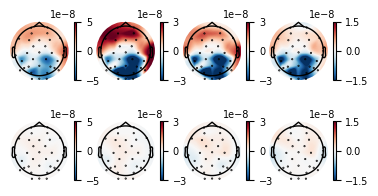

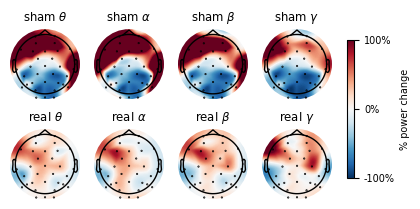

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

bp_subtracts = np.zeros((2, 32, 4))
bp_subtracts_norm = np.zeros((2, 32, 4))
bp_subtracts[0,:,:] = bp_table[1,:,:] - bp_table[0,:,:]
bp_subtracts[1,:,:] = bp_table[3,:,:] - bp_table[2,:,:]
bp_subtracts_norm[0,:,:] = bp_subtracts[0,:,:] / bp_table[0,:,:]
bp_subtracts_norm[1,:,:] = bp_subtracts[1,:,:] / bp_table[2,:,:]

raw = fe.channel_pos()

band_names = ['$\u03B8$', '$\u03B1$', '$\u03B2$', '$\u03B3$']
group_names = ['sham', 'real']

cm = 1/2.54
fig, axes = plt.subplots(nrows=len(group_names), ncols=len(band_names), figsize=(9.4*cm, 5*cm))
cbar_lim = [(-5e-8, 5e-8), (-3e-8, 3e-8), (-3e-8, 3e-8), (-1.5e-8, 1.5e-8)]

for k, band_name in enumerate(band_names):
    for i, group_name in enumerate(group_names):
        ax = axes[i, k]  # Get the correct axis from the grid
        im, cn = mne.viz.plot_topomap(bp_subtracts[i,:,k], pos=raw.info, axes=ax, show=False, contours=0, vlim=cbar_lim[k])
        # Add title to each subplot
        # ax.set_title(group_name + ' ' + band_name)

        # Create an axis for the color bar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        
        # Add the color bar to the current subplot
        cbar = plt.colorbar(im, cax=cax, orientation='vertical')
        cbar.set_ticks([cbar_lim[k][0], 0, cbar_lim[k][1]])


# fig.suptitle(case_title, fontsize=20, y=1.08)
matplotlib.rcParams.update({'font.size': 7})
fig.subplots_adjust(left=0.01, bottom=0.01, right=0.89, top=0.94)
plt.subplots_adjust(wspace=0.3)
# plt.tight_layout()
save_path = os.path.join('..', '..', '..', '..', 'paper', 'Figure 4', case_title+'_topos.eps')
plt.savefig(save_path, format='eps')
plt.show()


cm = 1/2.54
fig, axes = plt.subplots(nrows=len(group_names), ncols=len(band_names), figsize=(9.4*cm, 5*cm))
cbar_lim = (-1, 1)

for k, band_name in enumerate(band_names):
    for i, group_name in enumerate(group_names):
        ax = axes[i, k]  # Get the correct axis from the grid
        im, cn = mne.viz.plot_topomap(bp_subtracts_norm[i,:,k], pos=raw.info, axes=ax, show=False, contours=0, vlim=cbar_lim)
        # Add title to each subplot
        ax.set_title(group_name + ' ' + band_name)

# Add a colorbar to the right of the subplots grid
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_ticks([-1, 0, 1])
cbar.set_ticklabels(['-100%', '0%', '100%'])

cbar.set_label('% power change')
matplotlib.rcParams.update({'font.size': 7})
fig.subplots_adjust(left=0.01, bottom=0.01, right=0.88, top=0.94)
save_path = os.path.join('..', '..', '..', '..', 'paper', 'Figure S3', case_title+'_topos_norm.eps')
# plt.savefig(save_path, format='eps')
plt.show()